# Breast Control Experiment

Run 3 experiments:
- n-of-1 vs All Breast
- n-of-1 vs Breast Subset (~10 samples)
- n-of-1 vs Breast subset + all other tissues

Compare PPP and outlier values

# Inputs

In [27]:
import warnings
warnings.filterwarnings('ignore')

import rnaseq_lib3 as r
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
from sklearn.feature_selection import SelectKBest

In [80]:
df.head()

,id,tissue,subtype,tumor,label,RP11-40C6.2,IGHG1,IGKC,KRT5,IGLC2,...,IGHEP1,RP11-44N21.4,GAPDHP61,P2RX5-TAX1BP3,RP11-408H20.3,RP13-726E6.2,CTB-43E15.1,ZNF878,OR2H2,RP4-530I15.9
GTEX-UTHO-1226-SM-3GAEE,GTEX-UTHO-1226-SM-3GAEE,Heart,Heart_Atrial_Appendage,no,gtex,-1.211260,0.905252,0.674399,-0.175369,0.388792,...,-0.261452,-0.391506,-0.309631,-0.740657,-0.401758,-0.681096,-0.356918,-0.719266,2.029397,1.837806
GTEX-146FH-1726-SM-5QGQ2,GTEX-146FH-1726-SM-5QGQ2,Esophagus,Esophagus_Mucosa,no,gtex,-0.502883,0.539459,0.610233,2.222542,0.554726,...,0.303442,-0.391506,-0.309631,0.095169,-0.401758,-0.116008,-0.356918,1.052202,-0.370071,0.435850
GTEX-QDT8-0126-SM-48TZ1,GTEX-QDT8-0126-SM-48TZ1,Skin,Skin_Sun_Exposed_(Lower_leg),no,gtex,-0.557445,-0.825342,-0.894589,1.765345,-0.561263,...,-0.261452,-0.391506,0.172743,-0.699182,5.255706,-0.681096,0.891968,-0.420741,1.016892,1.067122
GTEX-QCQG-1326-SM-48U24,GTEX-QCQG-1326-SM-48U24,Uterus,Uterus,no,gtex,-1.211260,-0.604086,-0.835154,-0.446600,-0.979139,...,-0.261452,-0.391506,0.214217,0.332293,-0.401758,0.387489,-0.356918,0.578169,1.275865,1.067122
GTEX-WZTO-2926-SM-3NM9I,GTEX-WZTO-2926-SM-3NM9I,Brain,Brain_Cortex,no,gtex,-1.211260,-1.231433,-1.273151,-0.184560,-1.195402,...,-0.261452,-0.391506,-0.128336,2.117556,0.739453,-0.034883,-0.356918,-0.944930,1.050123,-0.379422


In [4]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
# Subset
gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

Drug genes

In [5]:
drug_genes = [x.split('\t')[0] for x in open('../../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

Build comparison sets

In [6]:
n_of_1 = tumor.loc['TCGA-BH-A0DS-01']
breast = gtex[gtex.tissue == 'Breast']
# Breast subset
random_breast = np.random.choice(breast.id, 10)
breast_sub = breast.loc[random_breast]
# Combined
combined = pd.concat([breast_sub, gtex[gtex.tissue != 'Breast']])

Select gene set

In [7]:
genes = df.columns[5:]
training_genes = r.outlier.select_k_best_genes(gtex, genes, 'tissue') + ['JAK2', 'PARP1']

# N-of-1 vs. All Breast

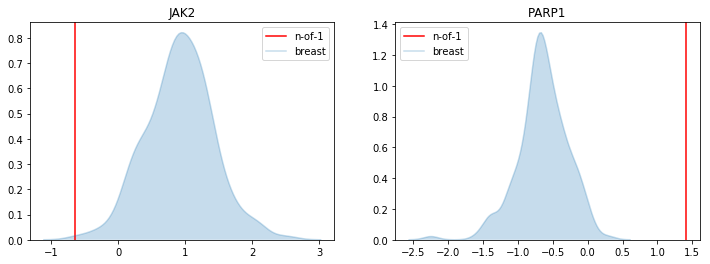

In [8]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['JAK2', 'PARP1']):
    ax[i].axvline(n_of_1[gene], c='r', label='n-of-1')
    sns.kdeplot(breast[gene], label='breast', shade=True, alpha=0.25, ax=ax[i])
    ax[i].set_title(gene)

In [9]:
m_a, t_a = r.outlier.model(n_of_1, breast, 'tissue', training_genes=training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:20<00:00, 74.62draws/s] 


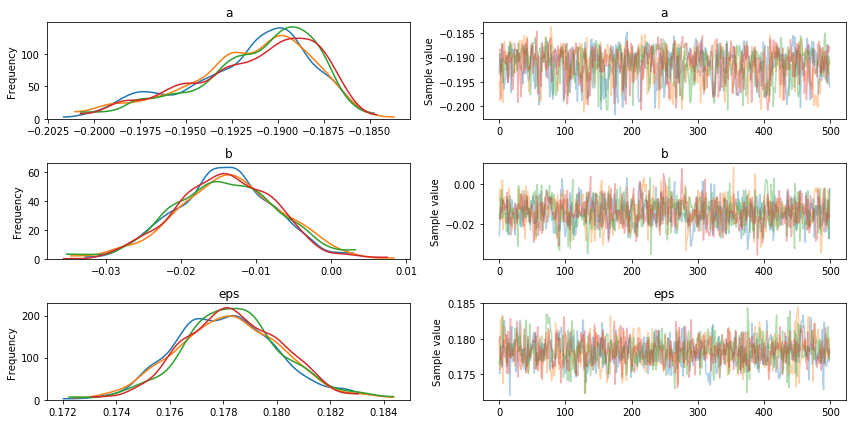

In [10]:
pm.traceplot(t_a);

In [11]:
ppc_a = pm.sample_ppc(t_a, model=m_a)

100%|██████████| 500/500 [00:44<00:00, 11.20it/s] 


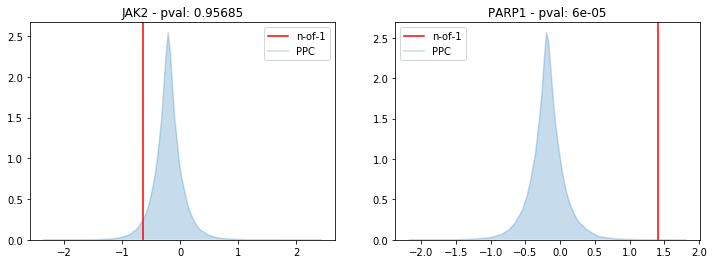

In [12]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['JAK2', 'PARP1']):
    ax[i].axvline(n_of_1[gene], c='r', label='n-of-1')
    
    z = ppc_a[gene].ravel()
    sns.kdeplot(z, label='PPC', shade=True, alpha=0.25, ax=ax[i])

    ppp = round(sum(n_of_1[gene] < z) / len(z), 5)
    ax[i].set_title(f'{gene} - pval: {ppp}')

# N-of-1 vs. Breast Subset

In [13]:
m_b, t_b = r.outlier.model(n_of_1, breast_sub, 'tissue', training_genes=training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:35<00:00, 169.74draws/s]


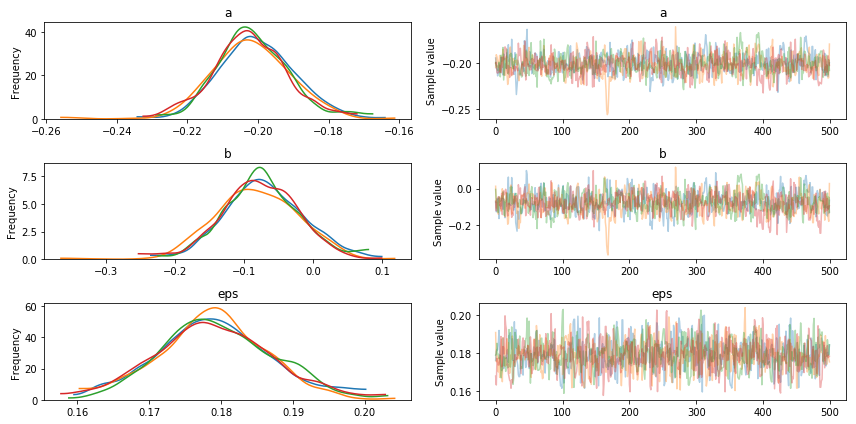

In [14]:
pm.traceplot(t_b);

In [17]:
ppc_b = pm.sample_ppc(t_b, model=m_b)

100%|██████████| 500/500 [00:45<00:00, 32.11it/s] 


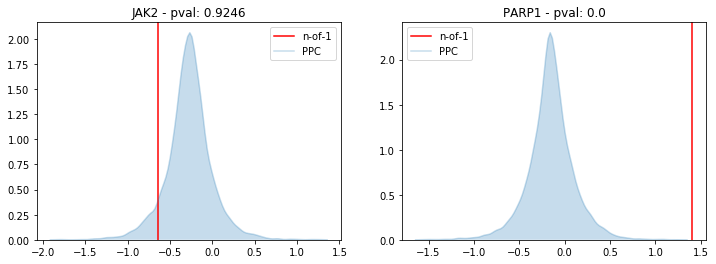

In [18]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['JAK2', 'PARP1']):
    ax[i].axvline(n_of_1[gene], c='r', label='n-of-1')
    
    z = ppc_b[gene].ravel()
    sns.kdeplot(z, label='PPC', shade=True, alpha=0.25, ax=ax[i])

    ppp = round(sum(n_of_1[gene] < z) / len(z), 5)
    ax[i].set_title(f'{gene} - pval: {ppp}')

# N-of-1 vs. Breast Subset + Other Tissues


In [15]:
m_c, t_c = r.outlier.model(n_of_1, combined, 'tissue', training_genes=training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [3:11:09<00:00,  1.99s/draws]  


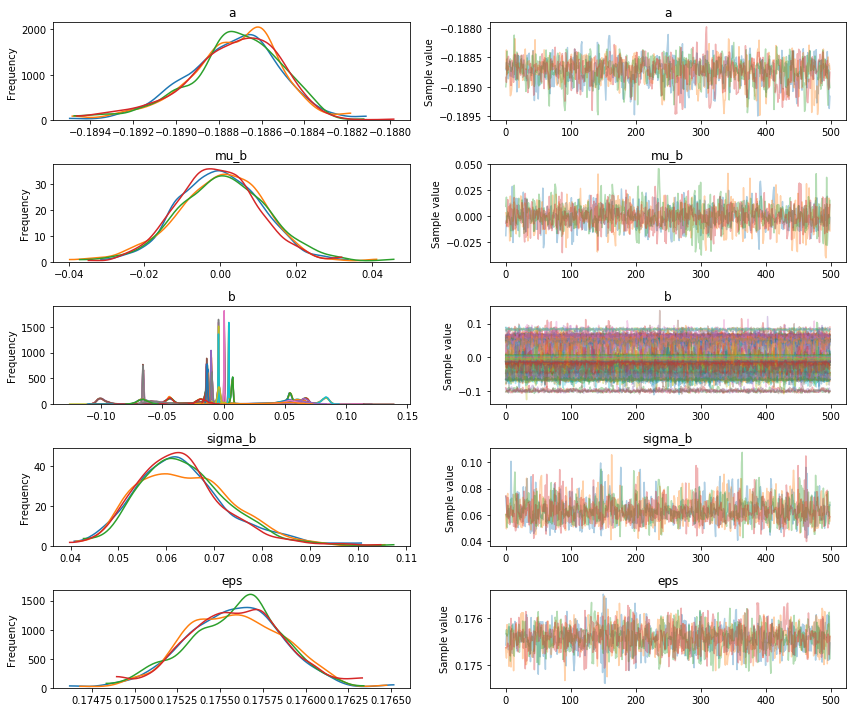

In [16]:
pm.traceplot(t_c);

In [19]:
ppc_c = pm.sample_ppc(t_c, model=m_c);

100%|██████████| 500/500 [01:35<00:00,  8.18it/s]


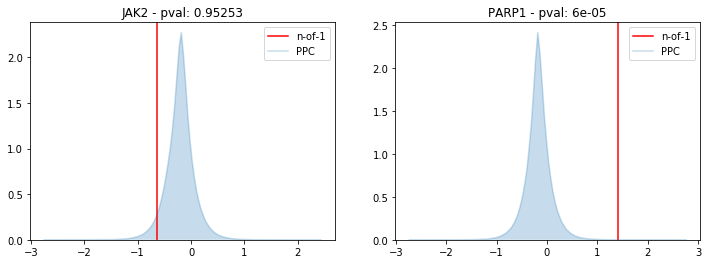

In [20]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['JAK2', 'PARP1']):
    ax[i].axvline(n_of_1[gene], c='r', label='n-of-1')
    
    z = ppc_c[gene].ravel()
    sns.kdeplot(z, label='PPC', shade=True, alpha=0.25, ax=ax[i])

    ppp = round(sum(n_of_1[gene] < z) / len(z), 5)
    ax[i].set_title(f'{gene} - pval: {ppp}')

# Compare Posterior P-Values

In [28]:
def posterior_pvals(ppc, sample, genes):
    pvals = {}
    for gene in tqdm(genes):
        z = ppc[gene].ravel()
        z_true = n_of_1[gene]
        pvals[gene] = round(sum(z_true < z) / len(z), 5)
    return pd.Series(pvals)

In [41]:
model_a = posterior_pvals(ppc_a, n_of_1, training_genes)
model_b = posterior_pvals(ppc_b, n_of_1, training_genes)
model_c = posterior_pvals(ppc_c, n_of_1, training_genes)

In [63]:
pvals = pd.concat([model_a, model_b, model_c], axis=1)
pvals.columns = ['Breast_179', 'Breast_10', 'GTEx_Breast_10']

In [73]:
pvals['b179_b10_se'] = (pvals.Breast_179 - pvals.Breast_10)**2 / len(pvals)
pvals['b179_gb10_se'] = (pvals.Breast_179 - pvals.GTEx_Breast_10)**2 / len(pvals)

In [76]:
pvals['b179_b10_se'].sum()

0.00014247608461538463

In [77]:
pvals['b179_gb10_se'].sum()

0.00021361580192307694

In [79]:
sorted(gtex.tissue.unique())

['Adipose',
 'Adrenal',
 'Artery',
 'Bladder',
 'Brain',
 'Breast',
 'Cells',
 'Cervix',
 'Colon',
 'Esophagus',
 'Fallopian',
 'Heart',
 'Kidney',
 'Liver',
 'Lung',
 'Minor',
 'Muscle',
 'Nerve',
 'Ovary',
 'Pancreas',
 'Pituitary',
 'Prostate',
 'Skin',
 'Small_intestine',
 'Spleen',
 'Stomach',
 'Testis',
 'Thyroid',
 'Uterus',
 'Vagina',
 'Whole']